<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Bipartite Networks 101</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint
import random

import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib
import matplotlib.pyplot as plt 

import networkx as nx

import PIL
import urllib

import tqdm as tq
from tqdm import tqdm

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 89792b254f9719f02fa81cd6ea98eef8c2259c89

numpy     : 1.19.2
tqdm      : 4.62.0
matplotlib: 3.3.2
PIL       : 8.0.1
json      : 2.0.9
pandas    : 1.1.3
watermark : 2.1.0
networkx  : 2.5



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load data

We'll be using the [Kaggle movie dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download). The first step is to load the movie metadata so that we can map the movie id to the respective title

In [4]:
movies = pd.read_csv('data/movies_metadata.csv.gz', usecols = ['id', 'title'])
movies = movies[(movies.id.map(lambda x: '-' not in x))].copy()
movies.id = movies.id.map(lambda x: 'm_' + str(x))
movies = dict(movies.values)

Next we load the credits data that connects each movie to the respective cast

In [5]:
data = pd.read_csv('data/credits.csv.gz')
data.drop_duplicates(inplace=True) # We have some duplicate rows

Each movie has three fields, Cast, Crew and id. Cast and Crew are json arrays that we must process

In [6]:
data

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862
...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506


We can extract all the data we want with just a few lines of code. For simplicity, we limit ourselves to just the first 3,000 movies

In [7]:
# Extract the actor information as well
actors = {}

# We keep two copies of the graph, a weighted and an unweighted version
# Graphs are stored as dict of dicts
graph = {}
graph_w = {}


for row, movie in tqdm(data.iloc[:1000].iterrows(), total=1000):
    # Add a prefix to the movie IDs
    movie_id = "m_" + str(movie.id)
    
    cast = eval(movie.cast)
    
    for actor in cast:
        # Add a prefix to the actor IDs
        actor_id = "a_" + str(actor['id'])
        
        if actor_id not in graph:
            graph[actor_id] = {}
            graph_w[actor_id] = {}

        graph[actor_id][movie_id] = 1.
        
        # Cast order is the order of the actor in the credits
        # 1 for the leading role, 2 for the co-star, etc
        graph_w[actor_id][movie_id] = 1./(actor['order']+1)

        if actor_id not in actors:
            actor_data = actor.copy()
            del actor_data['cast_id']
            del actor_data['character']
            del actor_data['credit_id']
            del actor_data['order']
            
            actors[actor_id] = actor_data

100%|██████████| 1000/1000 [00:00<00:00, 2082.42it/s]


In total we have over 12,000 actors

In [8]:
len(actors)

12063

And just over 45,000 movies

In [9]:
len(movies)

45433

# Adjacency Matrix

We convert our graph into an adjacency matrix

In [10]:
A = pd.DataFrame(graph).fillna(0)

In our reduced dataset we have 2,955 movies and 29,246 actors

In [11]:
A.info()

<class 'pandas.core.frame.DataFrame'>
Index: 982 entries, m_862 to m_22660
Columns: 12063 entries, a_31 to a_1787560
dtypes: float64(12063)
memory usage: 90.4+ MB


We compute the cosine similarity across movies

In [12]:
simil = cosine_similarity(A)

And set the diagonal to zero, for convenience

In [13]:
np.fill_diagonal(simil, 0)

As we can see, most of the similarities are pretty low

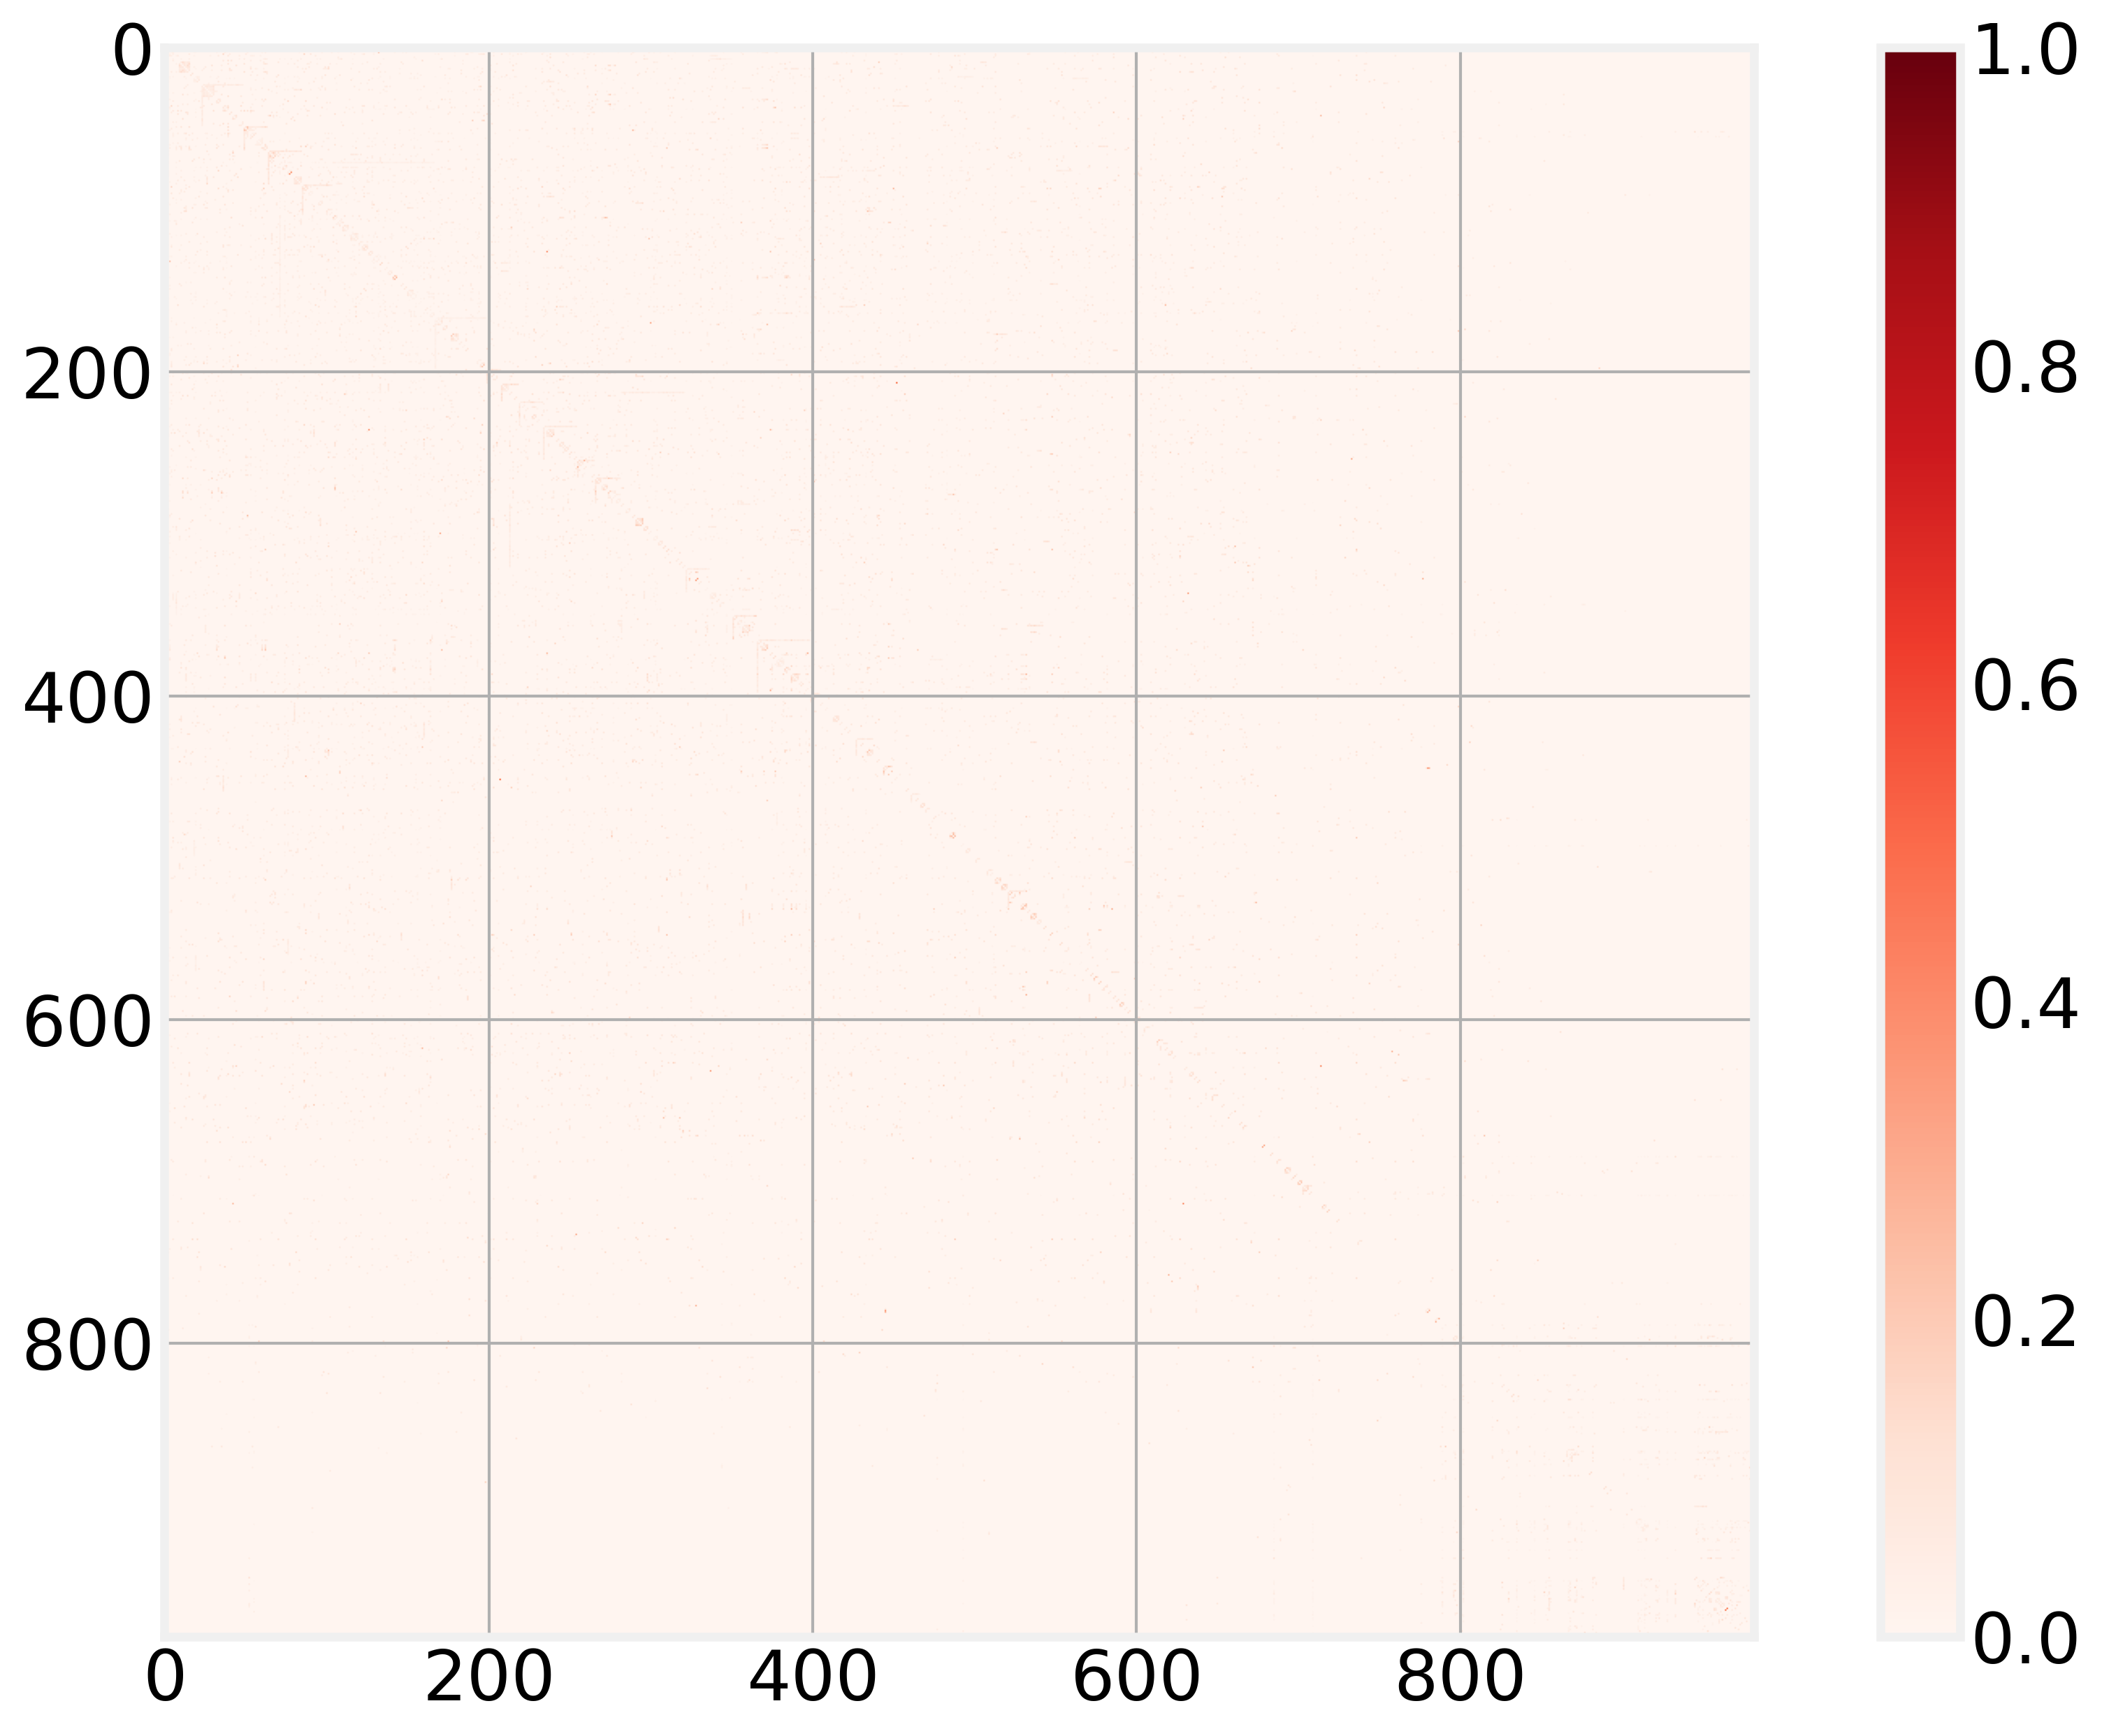

In [14]:
plt.imshow(simil, cmap=plt.cm.Reds, vmin=0, vmax=1)
plt.colorbar()

# Weighted Adjacency matrix

In this version of the adjacency matrix we weight each edge by the casting order of that actor in that movie. In this way, two movies with the same leading actor or actress will be closer than two movies with the same actor in a small role

In [15]:
W = pd.DataFrame(graph_w).fillna(0)

And compute the similarities

In [16]:
simil_w = cosine_similarity(W)
np.fill_diagonal(simil_w, 0)

Now we have a clear clustering pattern along the main diagonal. This is convenient for our purposes, but just an artifact of the way in which the dataset was generated. In general we would have a reorder the elements of the matrix to obtain this effect.

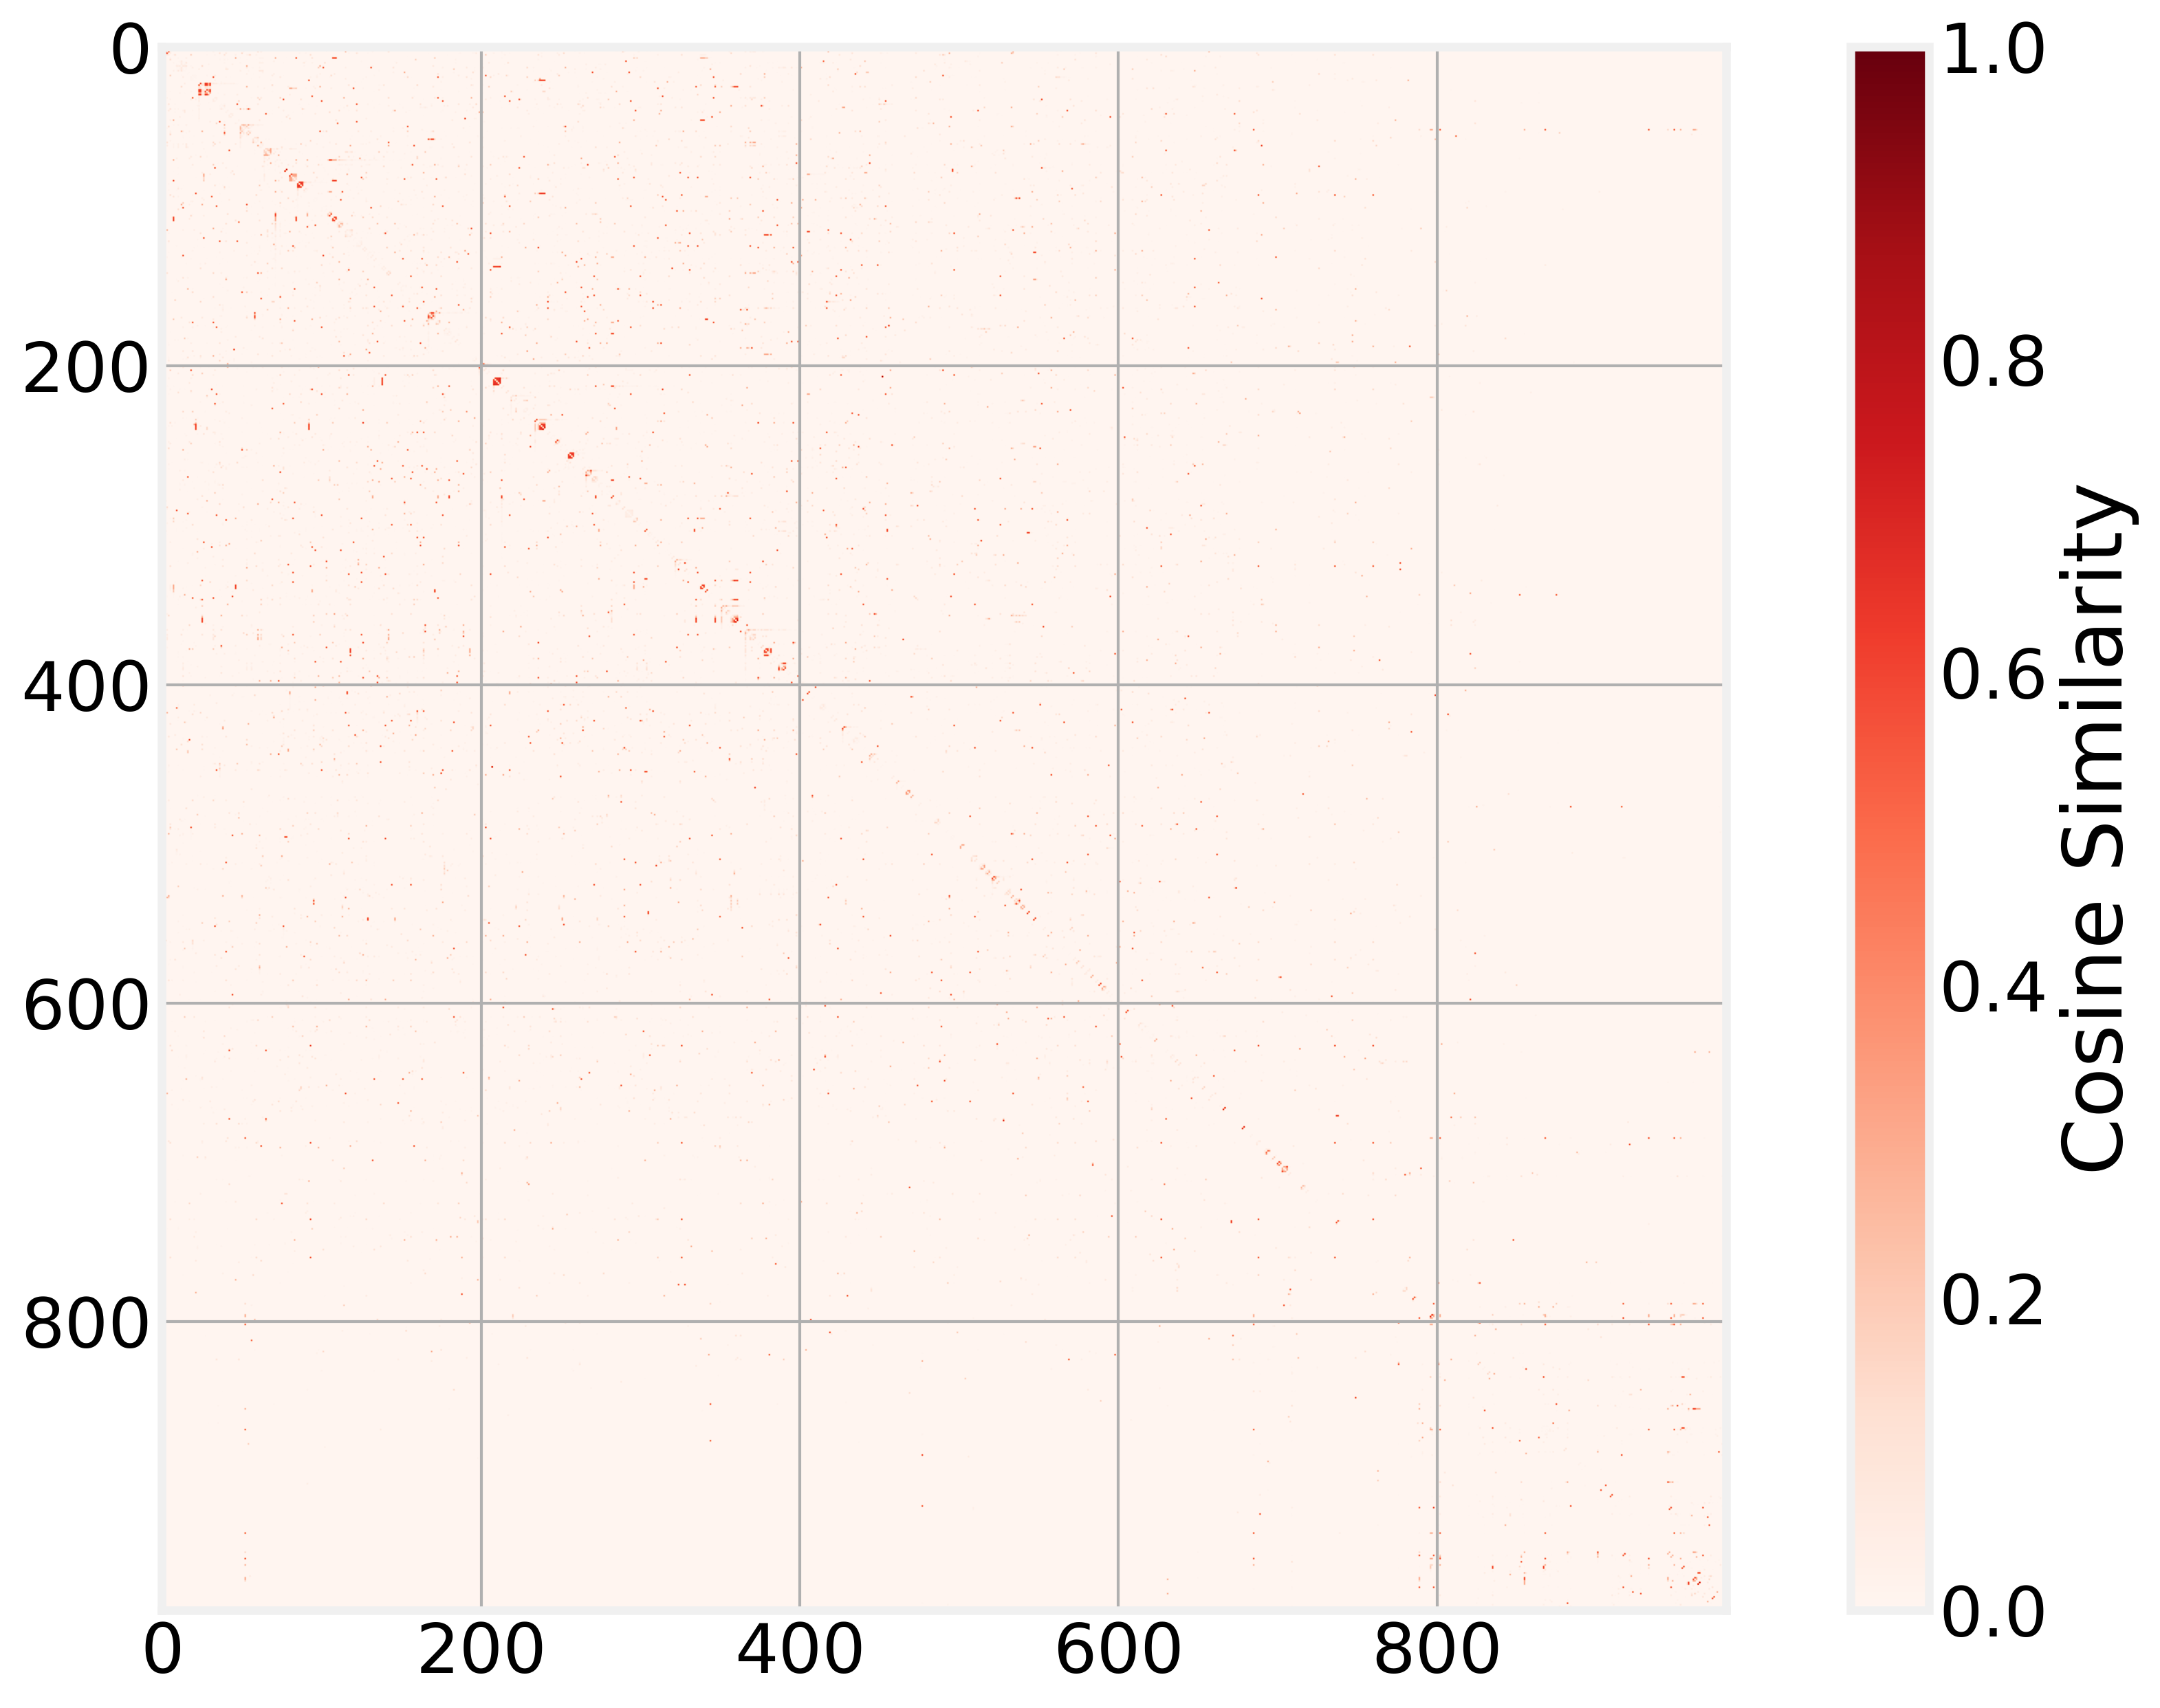

In [17]:
plt.imshow(simil_w, cmap=plt.cm.Reds, vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity')

When we zoom in to the upper left corner we can see a lot more details

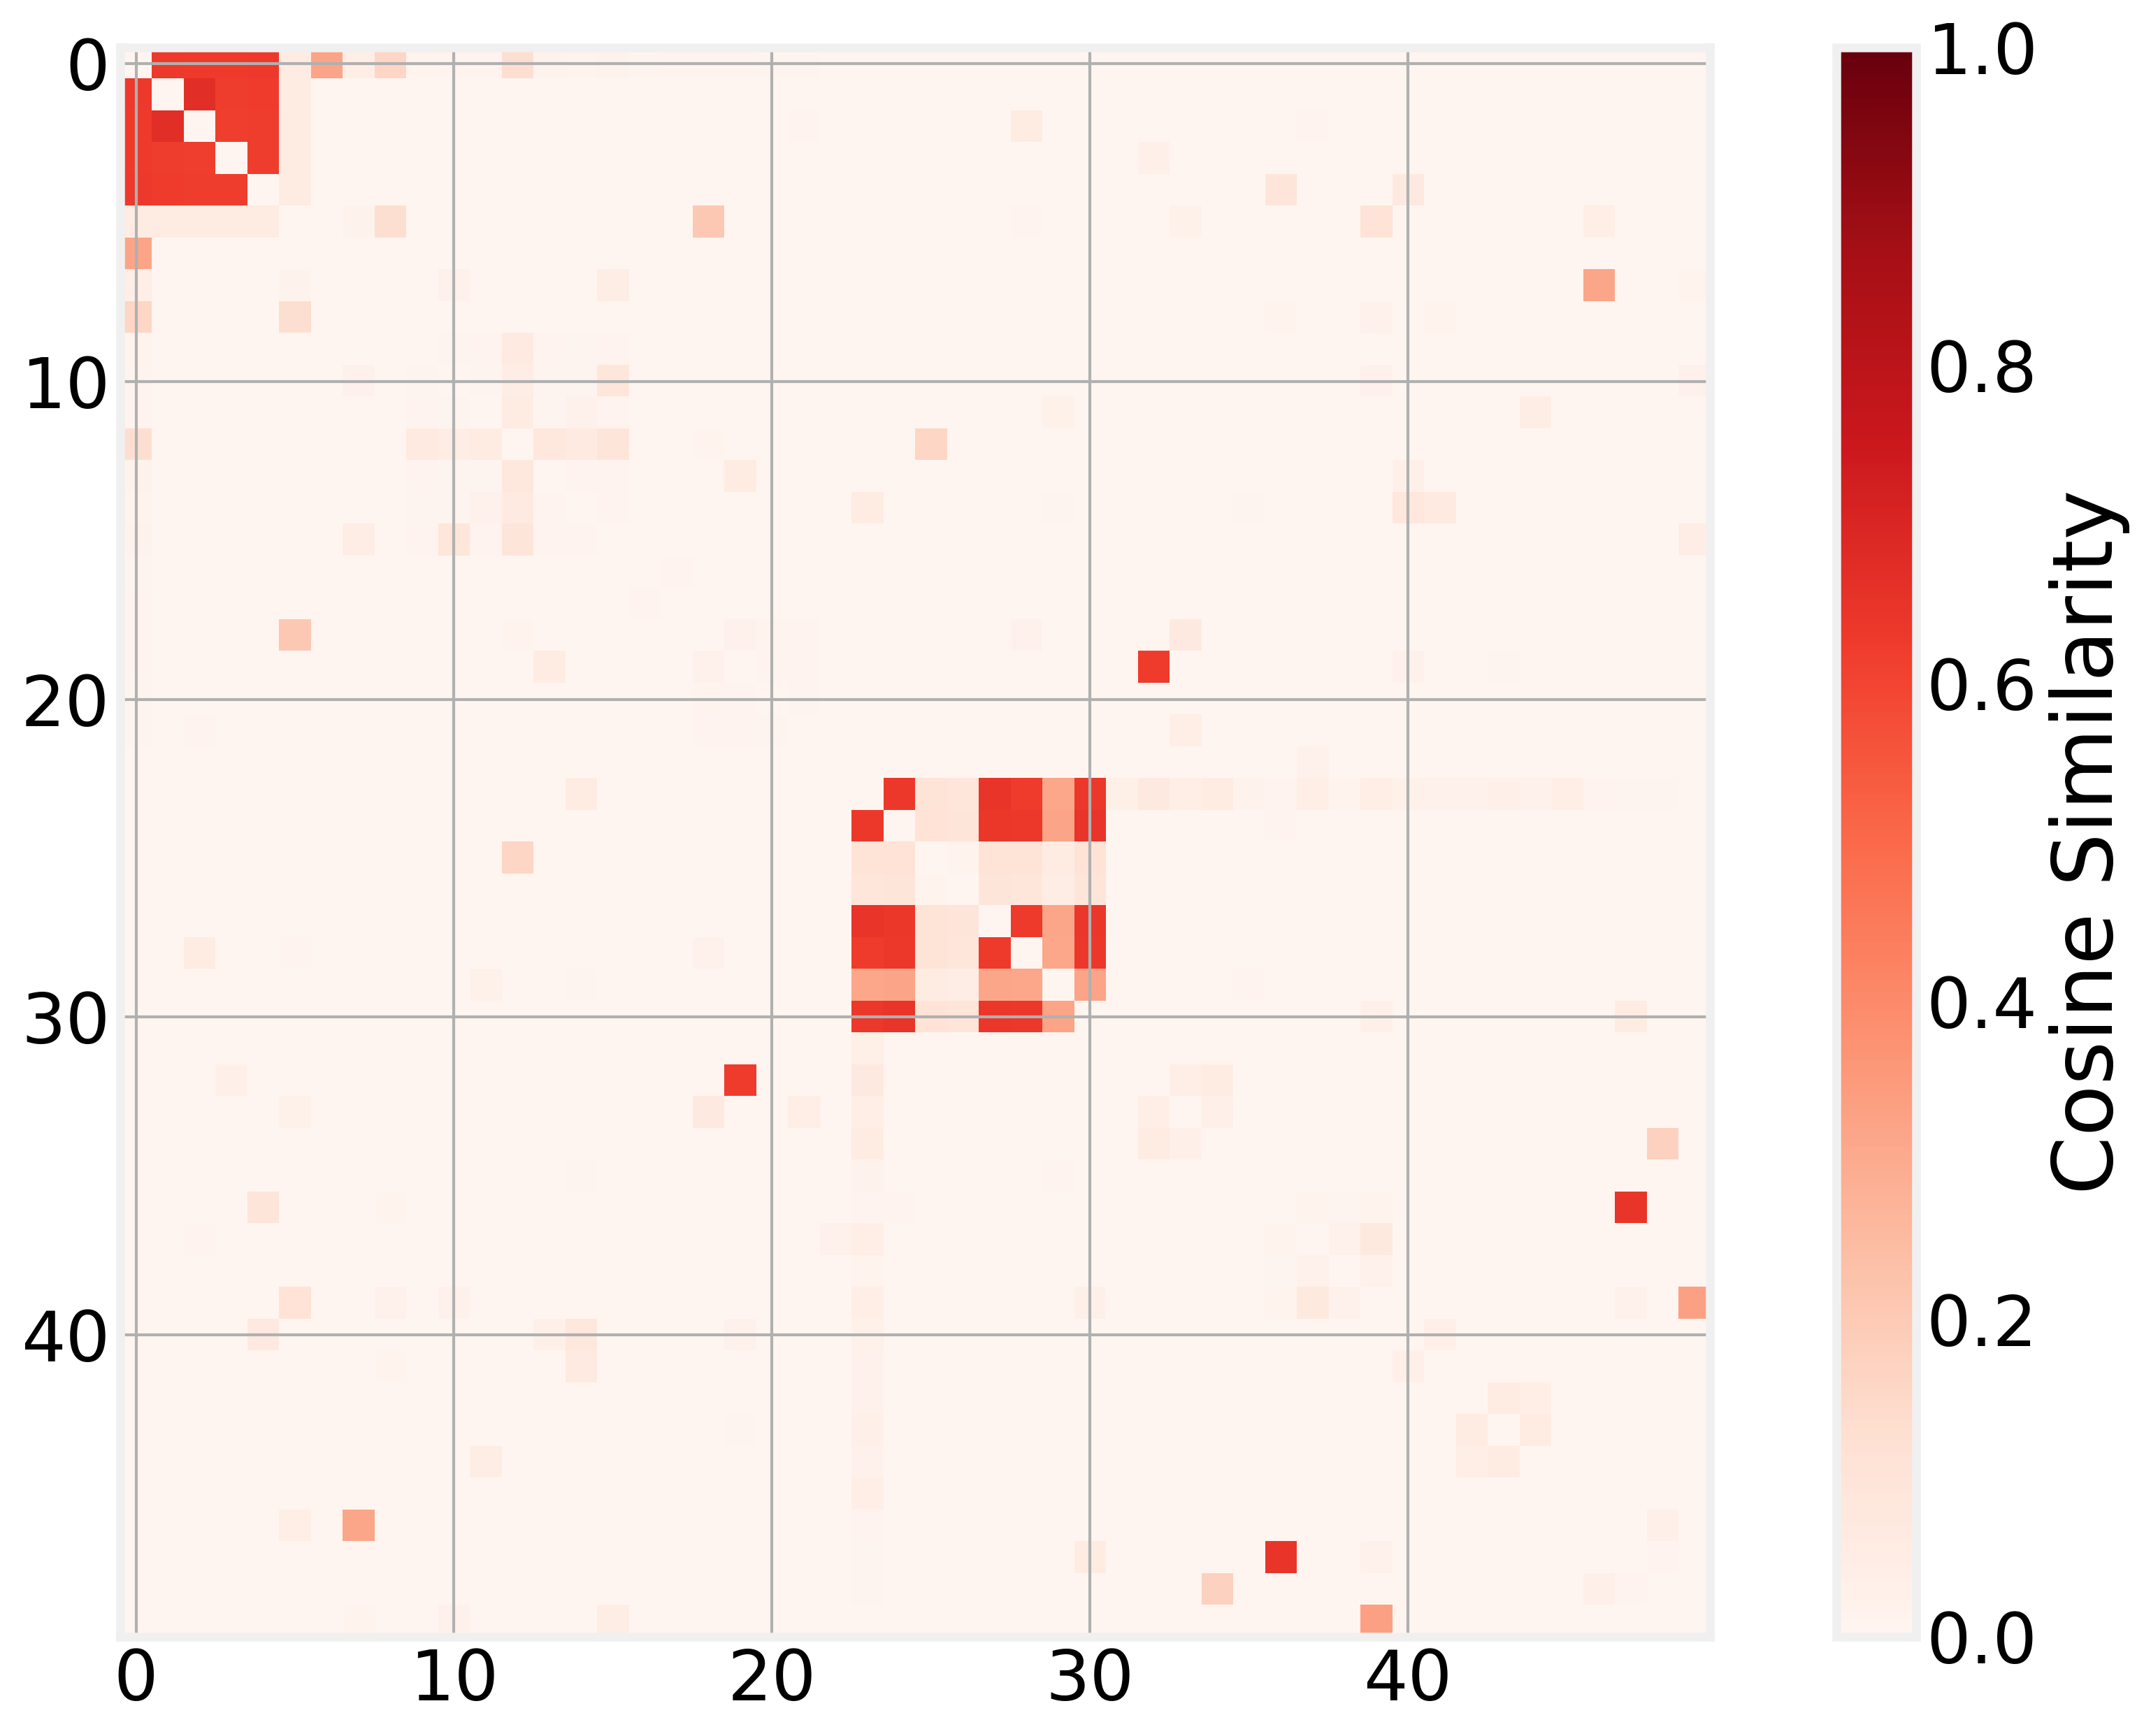

In [18]:
plt.imshow(simil_w[:50,:50], cmap=plt.cm.Reds, vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity')

Specially the first 5 movies, which shouldn't be surprising since these are all movies with Tom Hanks in a leading role

In [19]:
A.iloc[:5].index.map(lambda x: print(movies[x]));

Toy Story
Apollo 13
Forrest Gump
Philadelphia
Sleepless in Seattle


For comparison, we can look at the movie at position 5:

In [20]:
A.iloc[[5]].index.map(lambda x: print(movies[x]));

The Celluloid Closet


Which is a documentary, [The Celluloid Closet](https://www.imdb.com/title/tt0112651/?ref_=fn_al_tt_1), unrelated to Tom Hanks :) 

# Projections

We project the full bipartite network into the actor component

In [21]:
actor_network = A.T.dot(A)
np.fill_diagonal(actor_network.values, 0)

Now we have a DataFrame connecting actors to actors if they were part of the same movie. As we used the unweighted adjacency matrix, the values correspond to the number of movies in which both actors participated

In [22]:
actor_network

,a_31,a_12898,a_7167,a_12899,a_12900,a_7907,a_8873,a_1116442,a_12901,a_12133,...,a_1234992,a_5823,a_61303,a_5827,a_5829,a_5830,a_13392,a_403760,a_117714,a_1787560
a_31,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a_12898,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a_7167,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a_12899,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a_12900,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a_5830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
a_13392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
a_403760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
a_117714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [23]:
actor_network.shape

(12063, 12063)

We convert the values to unsigned integers to save some memory

In [24]:
actor_network = actor_network.astype('uint8')

In [25]:
actor_network.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12063 entries, a_31 to a_1787560
Columns: 12063 entries, a_31 to a_1787560
dtypes: uint8(12063)
memory usage: 139.2+ MB


We extract the position of the non-zero elements. These will be the edges in our weighted graph

In [26]:
edges = np.nonzero(actor_network[actor_network>=2].fillna(0).values)

And now we extract the corresponding values

In [27]:
weights = actor_network.values[edges]

And build our graph. By construction the network is undirected

In [28]:
G = nx.Graph()
G.add_weighted_edges_from(zip(*edges, weights))

For clarity of illustration, we select the Giant Connected Component

In [29]:
GCC_nodes = next(nx.connected_components(G))
GCC = G.subgraph(GCC_nodes)

And set node color and size based on the node degree

In [30]:
node_colors = [colors[min(deg-1, 8)] for node, deg in GCC.degree()]
node_sizes = [2*deg+30 for node, deg in GCC.degree()]

Compute the layout

In [31]:
np.random.seed(1337)
random.seed(1337)

layout = nx.layout.kamada_kawai_layout(GCC, weight="weight")

And plot the resulting network

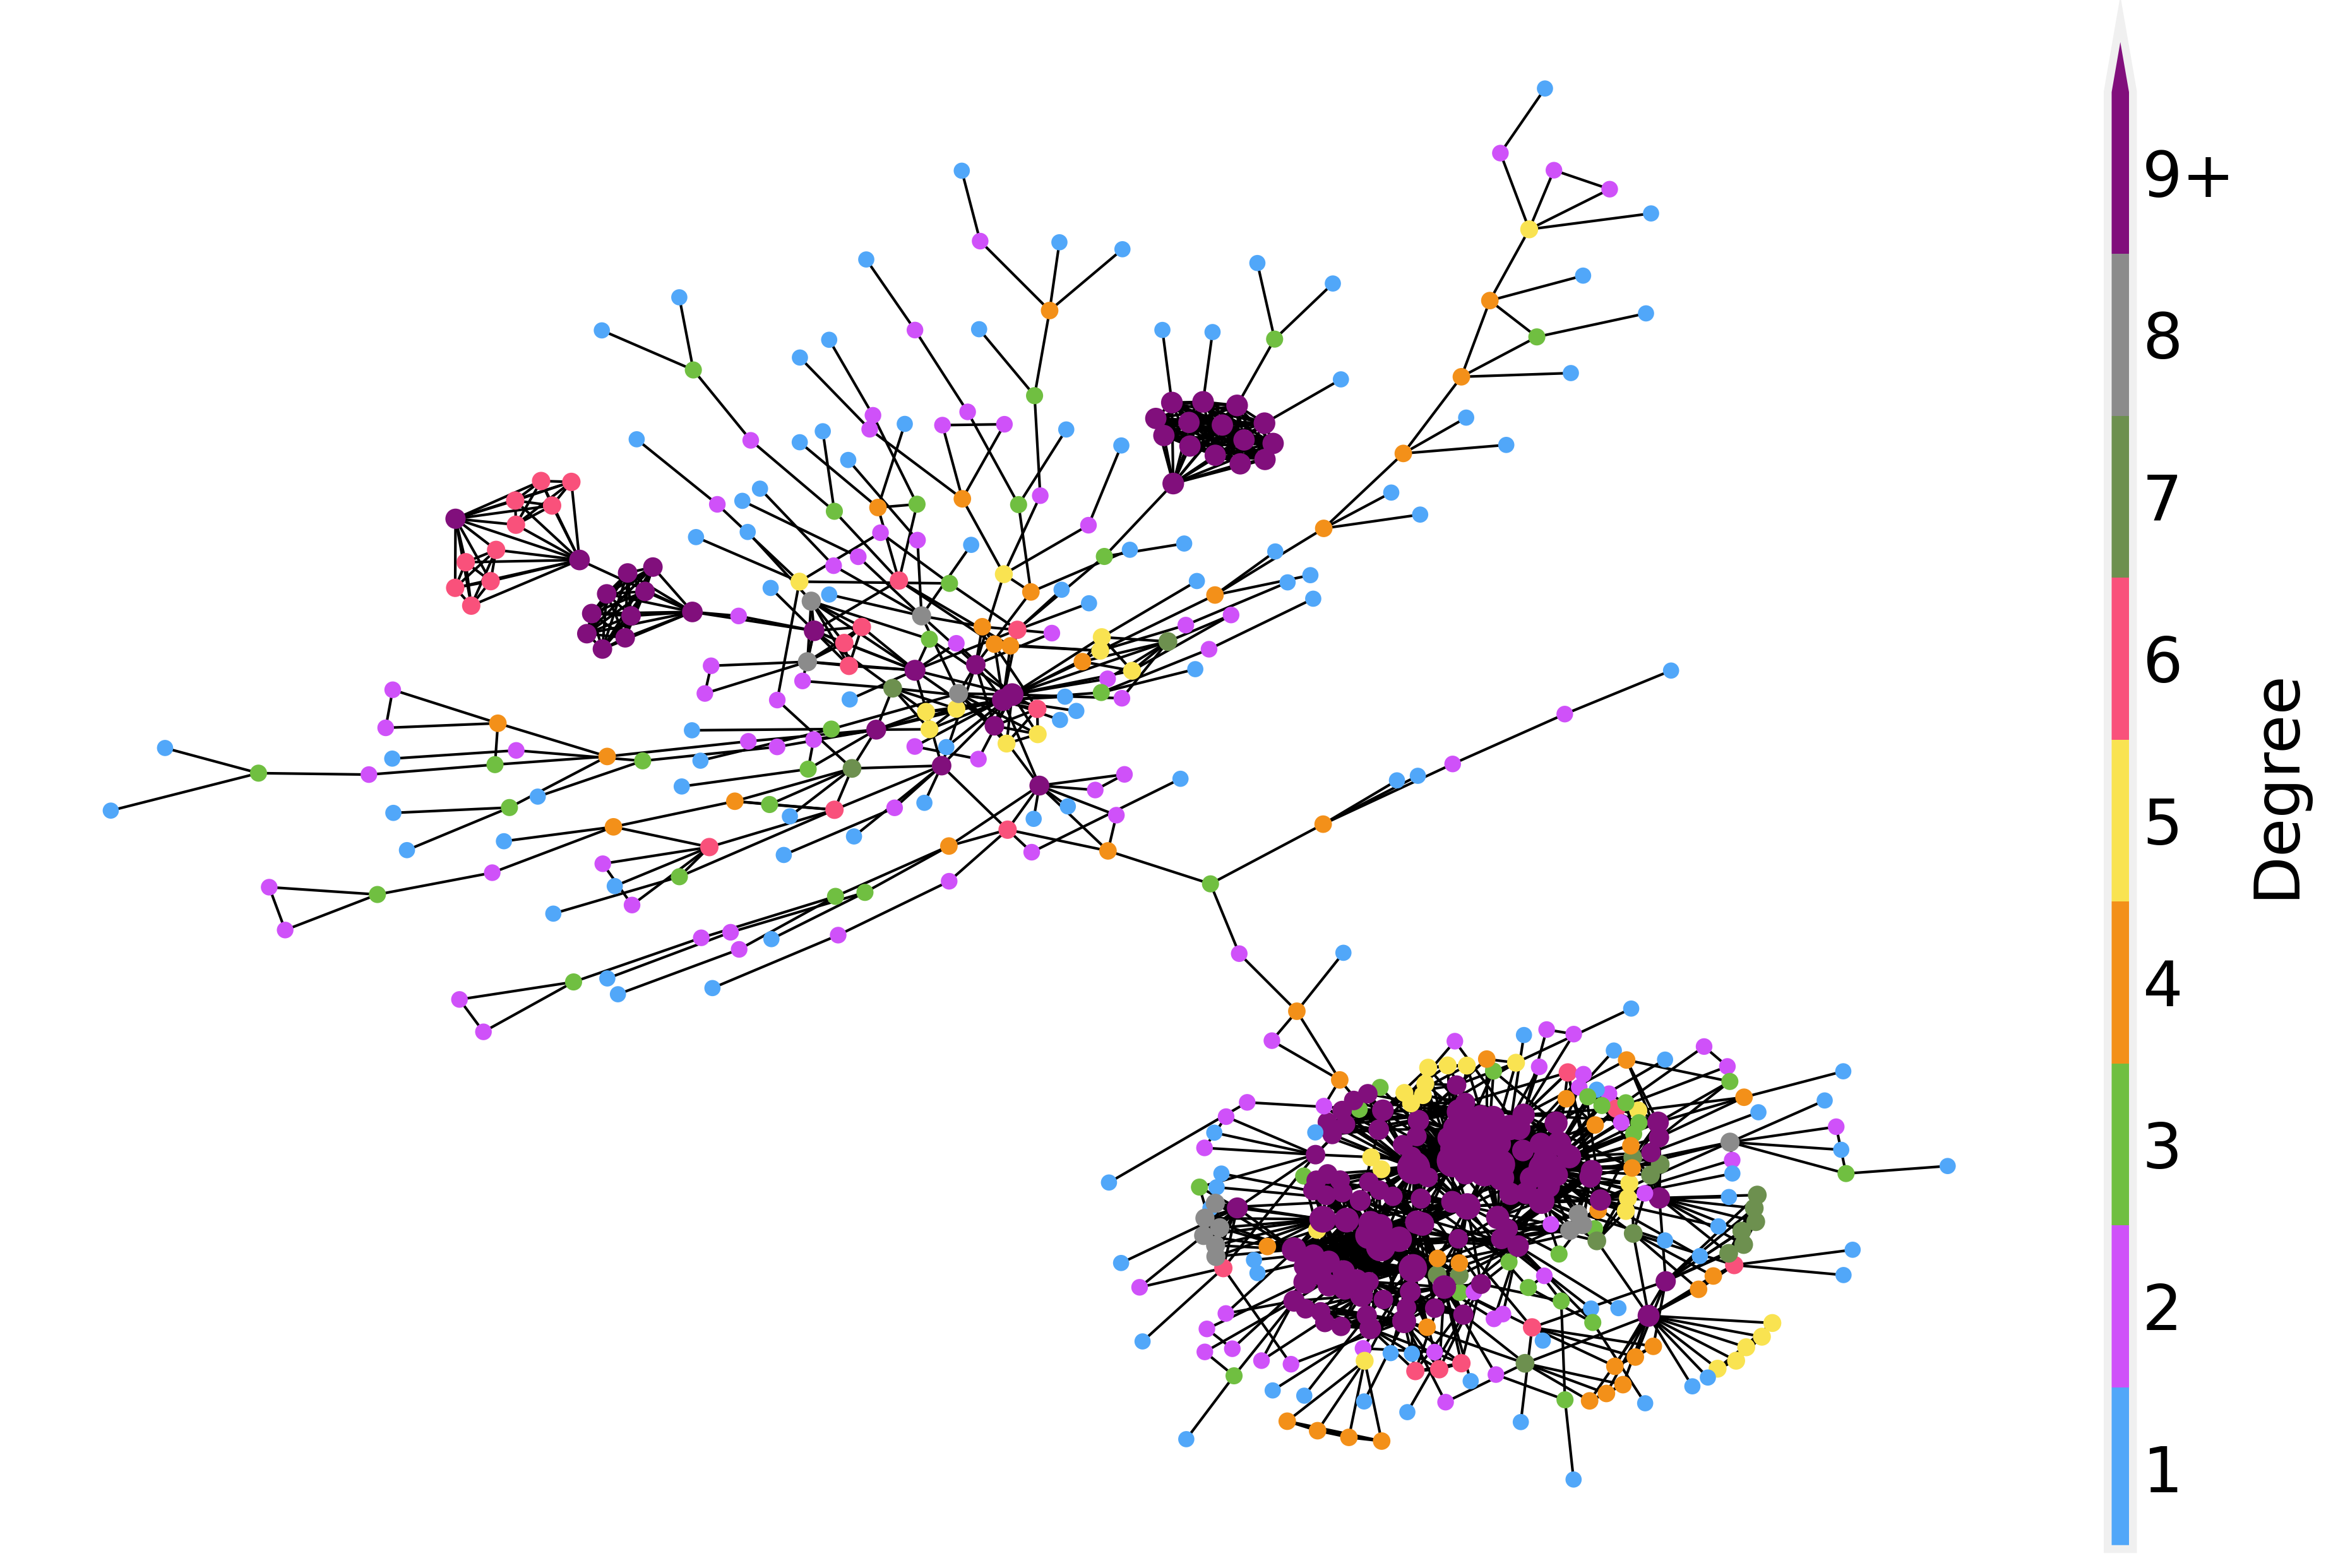

In [32]:
fig, (ax, cbax) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [80, 1]})

nx.draw(GCC, ax=ax, pos=layout, node_size=node_sizes, node_color=node_colors)

cmap = matplotlib.colors.ListedColormap(colors)

bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb2 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap,
                                norm=norm,
                                extend='max',
                                ticks=np.array(bounds)+0.5,
                                spacing='proportional',
                                orientation='vertical')

cb2.ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8, '9+'])
cb2.set_label('Degree', fontsize=24);

The denser clusters we observe correspond to teams of actors that often work together in the same movies

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>